In [88]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [89]:
from fastbook import *

In [90]:
path = Path("rice_leaf_diseases")

In [91]:
print(path)

rice_leaf_diseases


In [92]:
fns = get_image_files(path)

In [93]:
failed = verify_images(fns)
failed

(#0) []

In [94]:
# failed.map(Path.unlink)

Translates the data into a DataLoaders object by telling fastAI:
- the kind of data the model will be dealing with (ImageBlock in CategoryBlock)
- how to get the data (with the `get_image_files` function)
- how to create the validation set (here we configured the `RandomSplitter` so that 20 % of our data will be dedicated to the validation set)
- how to label the data (`parent_label`)

In [95]:
rld_datablock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

rld_datablock

`blocks=(ImageBlock, CategoryBlock)`:

The first element (`ImageBlock`) is the *independent variable*, i.e. the data from which the diseases detection model will be based on. In our case, it is images.

The second element of the tuple (`CategoryBlock`) is the *dependent variable*, i.e. what our model will try to detect. In our case, it is a category of diseases.

In [96]:
rld_dataloaders = rice_leaf_diseases_data_block.dataloaders(path)
rld_dataloaders

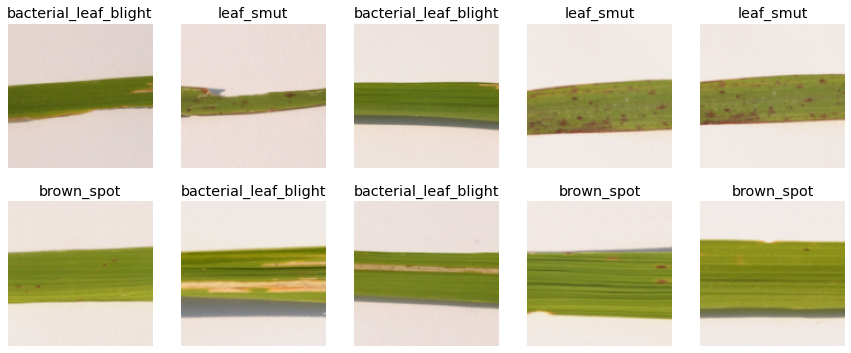

In [97]:
rld_dataloaders.show_batch(max_n=10, nrows=2)

In [98]:
rld_datablock = rld_datablock.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)
rld_dataloaders = rld_datablock.dataloaders(path)
rld_dataloaders

In [99]:
learner = cnn_learner(rld_dataloaders, resnet18, metrics=error_rate)
learner.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.635971,2.710642,0.666667,00:04


epoch,train_loss,valid_loss,error_rate,time
0,1.766852,2.013616,0.625000,00:04
1,1.567298,1.447840,0.625000,00:03
2,1.456696,0.878346,0.458333,00:03
3,1.265487,0.571024,0.291667,00:04
4,1.135019,0.506132,0.166667,00:04
5,1.037823,0.501695,0.208333,00:03
6,0.955594,0.492144,0.208333,00:03
7,0.880299,0.489787,0.208333,00:04
8,0.813487,0.454641,0.250000,00:04
9,0.773818,0.407579,0.250000,00:03


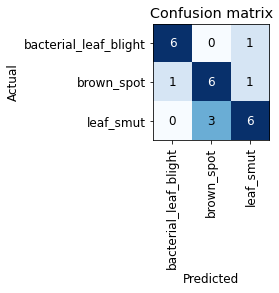

In [100]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

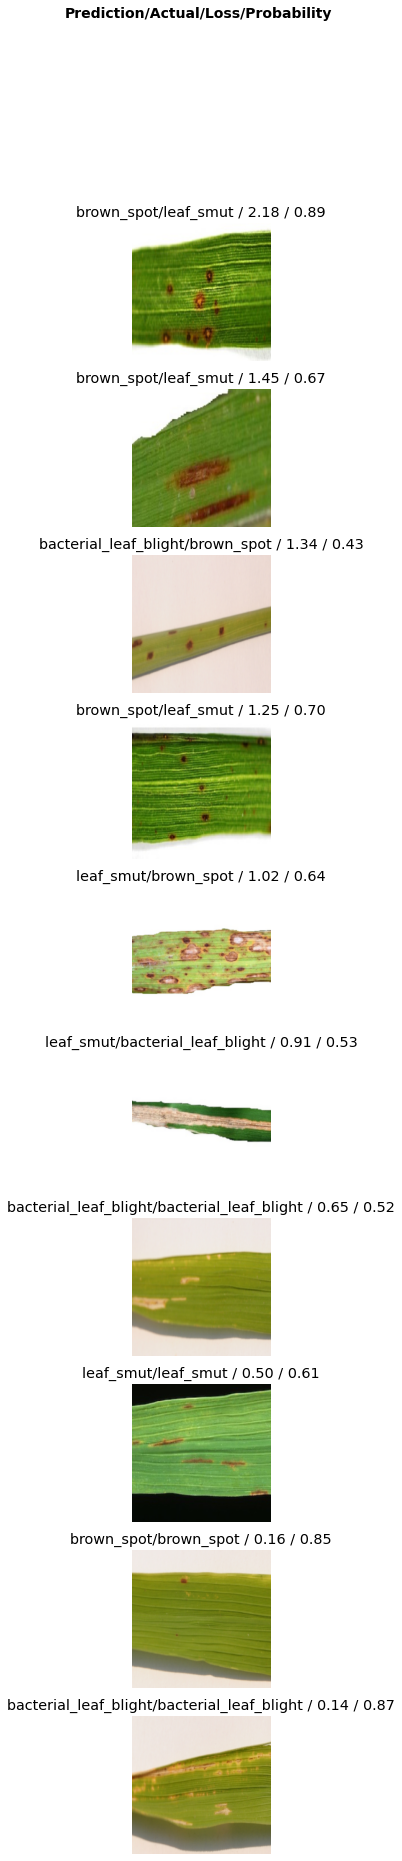

In [101]:
interp.plot_top_losses(10, nrows=10)

In [102]:
learner.export()
path = Path()
path.ls(file_exts=".pkl")
learner_inference = load_learner(path/"export.pkl")
learner_inference.predict("manual_validation/brown_spot.jpg")

('leaf_smut', tensor(2), tensor([0.0640, 0.0186, 0.9174]))

In [103]:
learner_inference.predict("manual_validation/bacterial_leaf_blight.jpg")

('bacterial_leaf_blight', tensor(0), tensor([0.9066, 0.0146, 0.0788]))

In [104]:
learner_inference.predict("manual_validation/leaf_smut.jpg")

('leaf_smut', tensor(2), tensor([0.0225, 0.0639, 0.9136]))